In [1]:
%%time
from tqdm.notebook import tqdm
import mediapipe as mp
import torch
from torch import nn, optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
# from torchvision.datasets import ImageFolder
import albumentations as A
# from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader, random_split, Dataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from arcface import ArcFaceLoss
import graphviz
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy, MulticlassConfusionMatrix
import torchvision
import json
import pandas as pd
from torchmetrics import MetricCollection
import os
import seaborn as sns
import torchvision.transforms.v2 as tf
from ds import VideoFrameDataset, ImglistToTensor
from torchvision.models.video.swin_transformer import swin3d_b, Swin3D_B_Weights
from torchvision.models.video.swin_transformer import swin3d_t, Swin3D_T_Weights


from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision("medium")
import pickle

from pytorch_lightning.utilities import grad_norm

# from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
# from pytorch_grad_cam import GradCAM

CPU times: user 9.18 s, sys: 1.6 s, total: 10.8 s
Wall time: 30.9 s


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
# pip freeze > requirements.txt

In [3]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

In [4]:
# torch.cuda.empty_cache()
print(torch.cuda.list_gpu_processes())

GPU:0
process    2810156 uses    22410.000 MB GPU memory


### Skeleton utilities

In [5]:
def get_skeleton_edges():
    del_mask = (np.arange(75) >= 15) & (np.arange(75) <= 22)  # True if point deleted
    pose_edges = mp.solutions.pose.POSE_CONNECTIONS
    hand_edges = mp.solutions.hands.HAND_CONNECTIONS
    edges = []
    for (u, v) in pose_edges:
        if del_mask[u] or del_mask[v]:
            continue
        edges.append((u, v))
    for (u, v) in hand_edges:
        edges.append((u + 33, v + 33))
        edges.append((u + 54, v + 54))
    edges.append((13, 33))
    edges.append((14, 54))
    return tuple(edges)


SKELETON_EDGES = get_skeleton_edges()
FRAME_WIDTH = 256
FRAME_HEIGHT = 256
FRAMES_PER_VIDEO = 32
NUM_CLASSES = 200

np.random.seed(2312)
EDGE_COLORS = tuple(tuple(int(i) for i in np.random.randint(10, 246, 3))
                    for e in SKELETON_EDGES)

In [6]:
def draw_skeleton(skeleton):
    frame = np.zeros((FRAME_WIDTH, FRAME_HEIGHT, 3), dtype=np.uint8)
    for (u, v), color in zip(SKELETON_EDGES, EDGE_COLORS):
        if np.isnan(skeleton[u]).any() or np.isnan(skeleton[v]).any(): 
            continue

        frame = cv2.line(frame,
                         np.round(skeleton[u] * FRAME_WIDTH).astype(np.int32),
                         np.round(skeleton[v] * FRAME_WIDTH).astype(np.int32),
                         color,
                         1)
    return frame

### Dataset

In [7]:
class NpToTensor(torch.nn.Module):
    @staticmethod
    def forward(img_list):
        return (torch.tensor(img_list.transpose(0, 3, 1, 2)).float() / 255)

In [8]:
def uniform_temporal_subsample(data, n_samples=FRAMES_PER_VIDEO):
    n_frames = len(data)
    indices = np.round(np.linspace(0, n_frames - 1, n_samples)).astype(np.int32)
    data = data[indices]
    return data

def random_binned_tss(data, n_samples=FRAMES_PER_VIDEO):
    n_frames = len(data)
    bounds = np.linspace(0, n_frames - 1, n_samples + 1)
    l, r = bounds[:-1], bounds[1:]
    ids = np.round(np.random.uniform(l, r)).astype(np.int32)
    return data[ids]

def random_clipped_tss_binned(data, n_samples=FRAMES_PER_VIDEO):
    l = np.random.randint(0, len(data) // 5)
    r = np.random.randint(len(data) + 1 - len(data) // 5, len(data) + 1)
    return random_binned_tss(data[l:r], n_samples)

def kuniformmean_tss(data, n_samples=FRAMES_PER_VIDEO, k=1):
    n_frames = len(data)
    ids = np.random.uniform(0, n_frames-1, (n_samples, k)).mean(axis=-1)
    ids = np.round(ids).astype(np.int32)
    ids = np.sort(ids)
    return data[ids]

def kuniformmean_randomshifted_tss(data, n_samples=FRAMES_PER_VIDEO, k=2):
    n_frames = len(data)
    sigma = n_frames / 15
    l = np.clip(np.random.normal(0, sigma), 0, 3 * sigma)
    r = n_frames - 1 - np.clip(np.random.normal(0, sigma), 0, 3 * sigma)
    
    ids = np.random.uniform(l, r, (n_samples, k)).mean(axis=-1)
    ids = np.round(ids).astype(np.int32)
    ids = np.sort(ids)
    return data[ids]

In [9]:
class SkeletonTransforms(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.alb_compose = A.Compose([
            A.Perspective(p=1.0),
            A.ShiftScaleRotate(rotate_limit=15, p=1.0, )
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        
        self.pointwise_tr = None # self._apply_point_noise
    
    def _apply_point_noise(self, points):
        noise = np.random.normal(0, 0.001, points.shape)
        return points + np.clip(noise, -0.004, 0.004)
    
    def _apply_alb(self, skeletons):
        input_shape = skeletons.shape
        points = skeletons.reshape(-1, input_shape[-1]) * FRAME_HEIGHT
        image = np.empty((FRAME_HEIGHT, FRAME_WIDTH))
        points = np.array(self.alb_compose(image=image, keypoints=points)['keypoints'])
        return points.reshape(*input_shape) / FRAME_HEIGHT
        
    def forward(self, skeletons: np.ndarray):
        """
            shape : [Frames, KeyPoints, Channels]
        """
        
        skeletons = self._apply_alb(skeletons)
        
        if self.pointwise_tr is not None:
            skeletons = self.pointwise_tr(skeletons)
            
        return skeletons

In [10]:
class SkeletonDS(torch.utils.data.Dataset):
    def __init__(self,
                 path2skeletons='data/autsl_skeleton/val_skeleton.pickle',
                 path2labels='data/autsl/val_labels.csv',
                 transform=NpToTensor(),
                 skeleton_transform=SkeletonTransforms(),
                 temporal_subsample=uniform_temporal_subsample,
                 ):
        super().__init__()
        self.transform = transform
        self.temporal_subsample = temporal_subsample
        self.skeleton_transform = skeleton_transform
        
        label_mapping = pd.read_csv(path2labels)
        with open(path2skeletons, 'rb') as file:
            skeleton_mapping = pickle.load(file)
        skeleton_mapping = {k.split('/')[-1][:-10]: v 
                            for k,v in skeleton_mapping.items()}
        
        self.samples = [(r[1], skeleton_mapping[r[0]])  
                        for i, r in label_mapping.iterrows() 
                        if  r[0] in skeleton_mapping]
        
    def __len__(self, ):
        return len(self.samples)
    
    def __getitem__(self, idx):
        label, skeletons = self.samples[idx]
        skeletons = self.temporal_subsample(skeletons)
        if self.skeleton_transform is not None:
            skeletons = self.skeleton_transform(skeletons)
        
        video = np.empty((FRAMES_PER_VIDEO, FRAME_HEIGHT, FRAME_WIDTH, 3), dtype=np.uint8)
        for i, skel in enumerate(skeletons):
            video[i] = draw_skeleton(skel)
        if self.transform is not None:
            video = self.transform(video)
        return (video, label)

In [11]:
train_ds = SkeletonDS('data/autsl_skeleton/train_skeleton.pickle', 
                      'data/autsl/train_labels.csv',
                      NpToTensor(),
                      SkeletonTransforms(),
                      random_clipped_tss_binned)

val_ds = SkeletonDS('data/autsl_skeleton/val_skeleton.pickle', 
                    'data/autsl/val_labels.csv',
                    NpToTensor(),
                    None,
                    random_binned_tss)

In [12]:
len(train_ds), len(val_ds)

(28131, 4417)

In [13]:
train_samples = [s for s in train_ds.samples if s[0] < NUM_CLASSES]
train_ds.samples = train_samples
val_samples = [s for s in val_ds.samples if s[0] < NUM_CLASSES]
val_ds.samples = val_samples

In [14]:
# train_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])
# len(train_ds)

In [15]:
def batch_as_list_collate(batch_samples):
    return batch_samples

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=6, drop_last=True, pin_memory=False)#, collate_fn=batch_as_list_collate)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=6, pin_memory=False)#, collate_fn=batch_as_list_collate)
# test_loader = DataLoader(test_ds, batch_size=12, shuffle=False, num_workers=8, pin_memory=False)#, collate_fn=batch_as_list_collate)

In [16]:
points = train_ds.samples[10][1]

In [17]:
tr = SkeletonTransforms()

In [18]:
tr_points = tr(points)

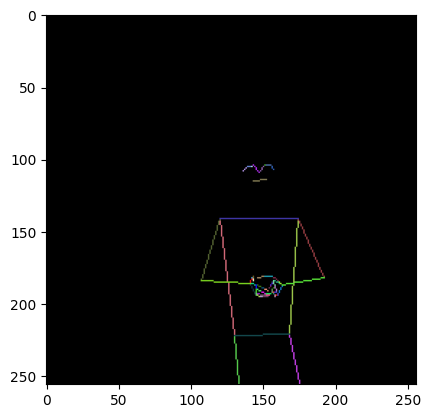

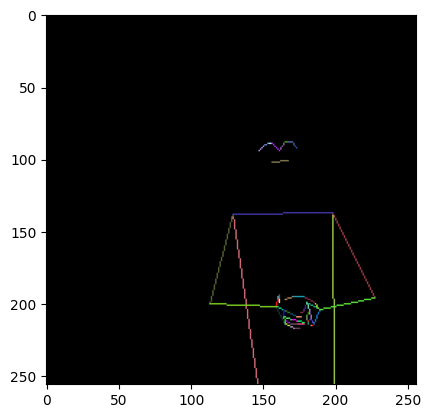

In [19]:
plt.imshow(draw_skeleton(points[10]))
plt.show()
plt.imshow(draw_skeleton(tr_points[10]))


32


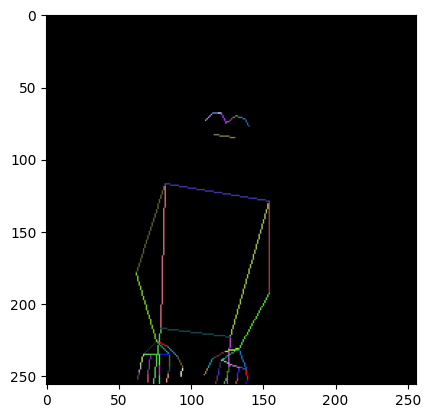

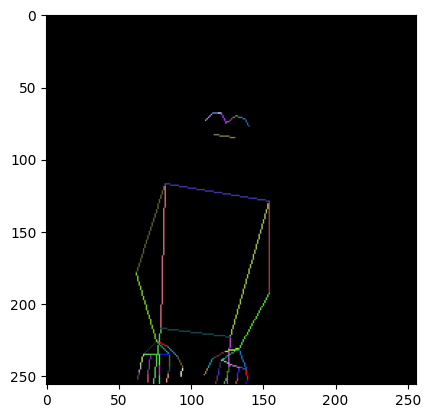

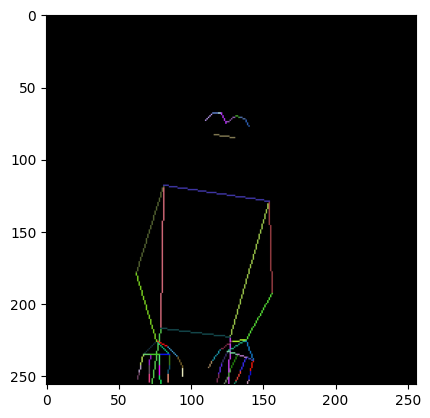

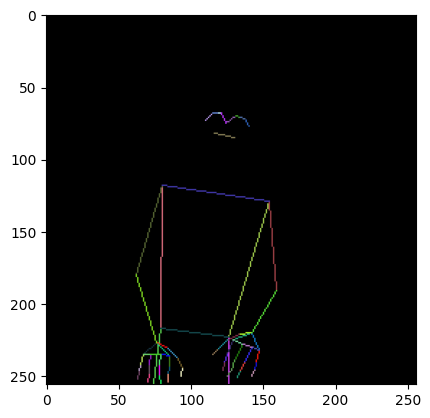

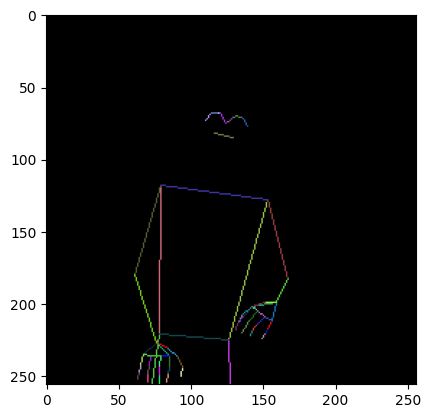

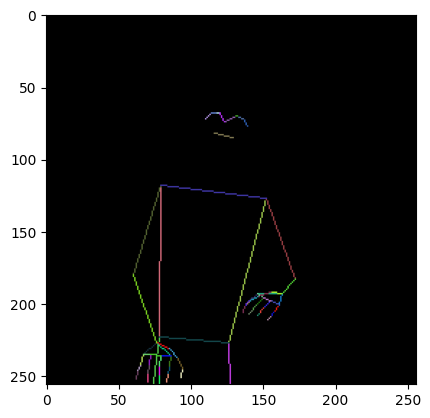

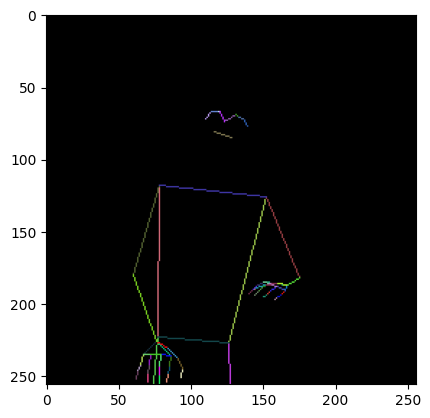

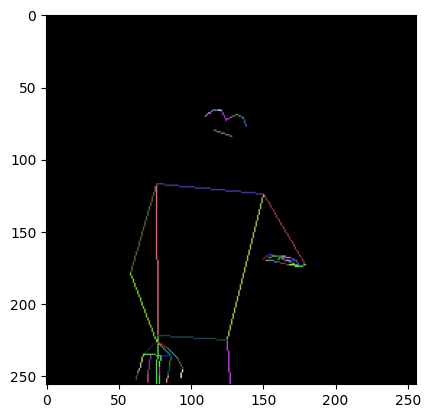

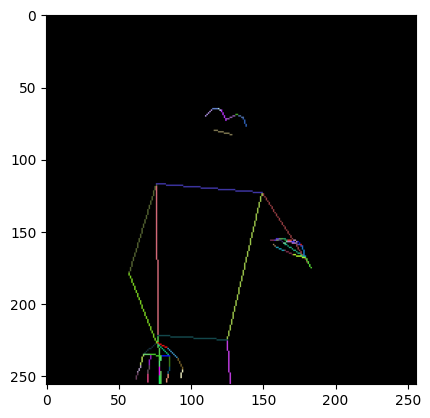

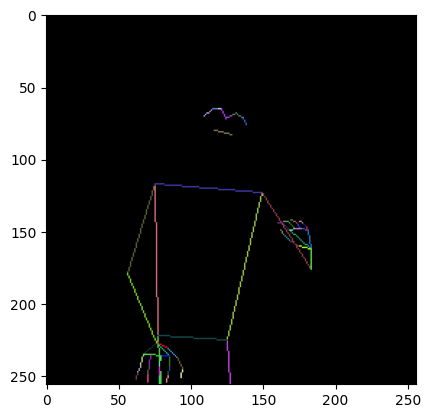

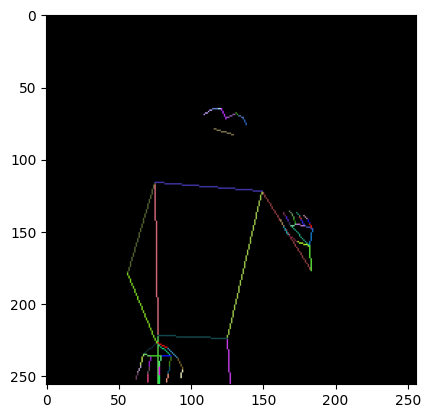

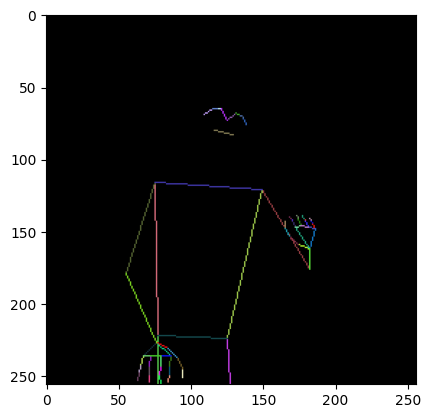

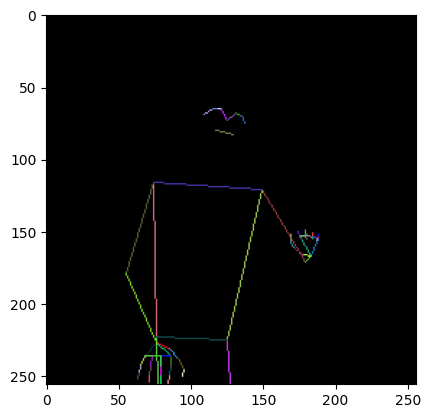

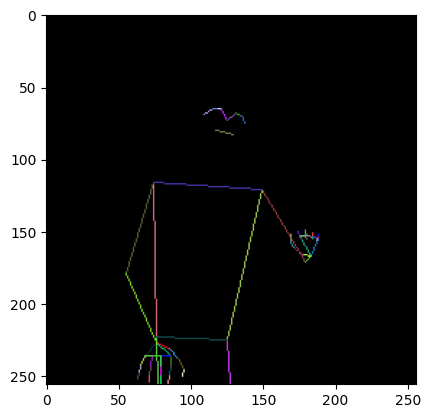

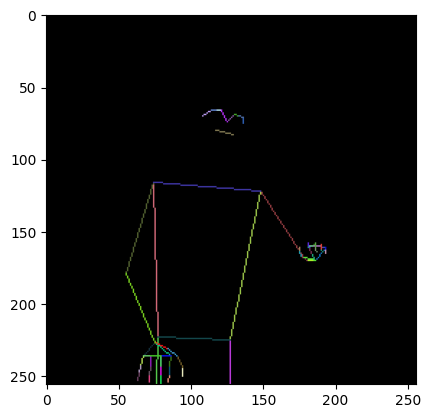

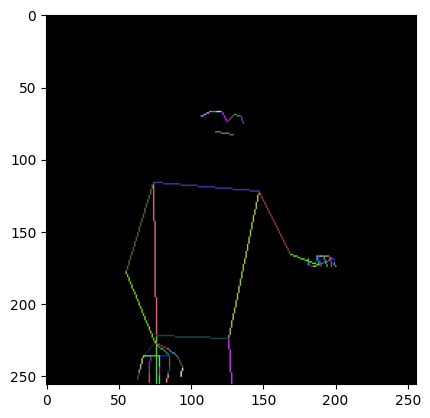

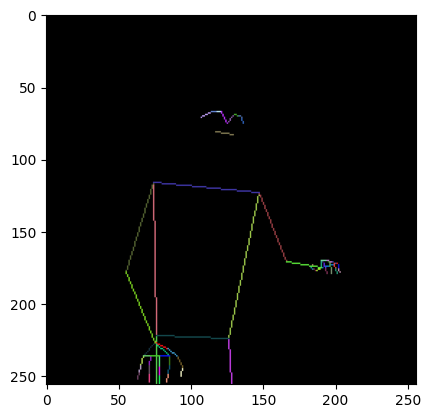

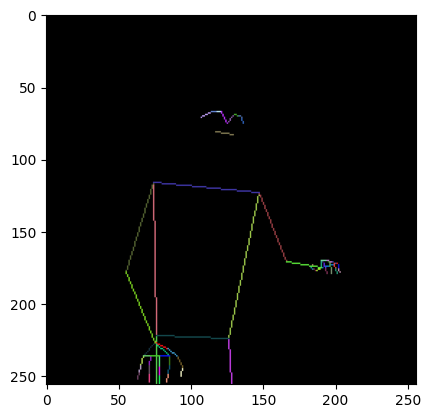

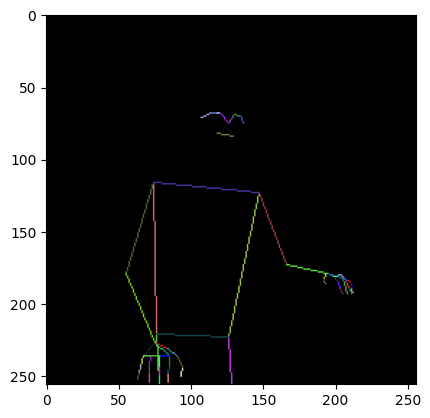

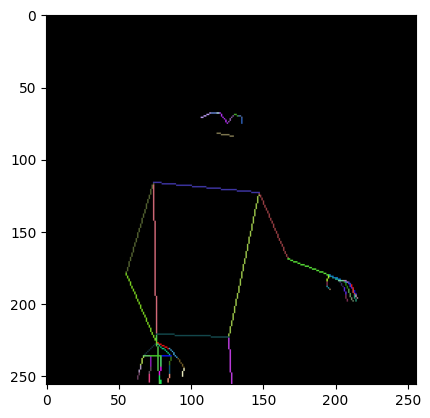

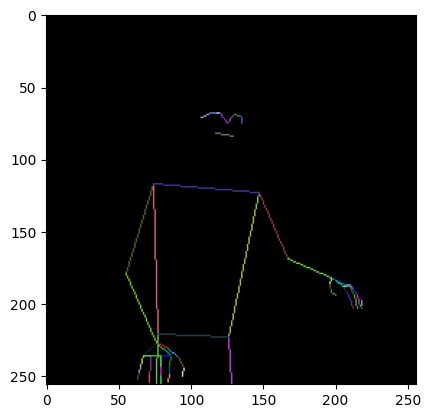

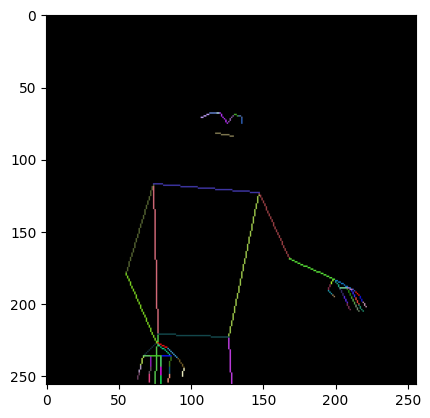

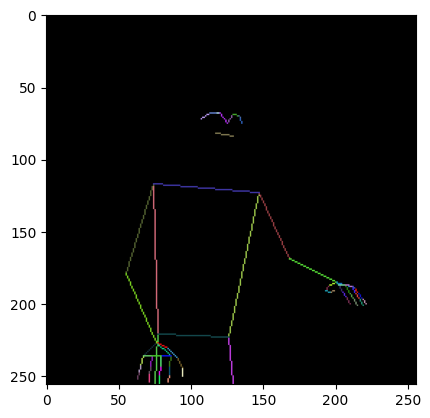

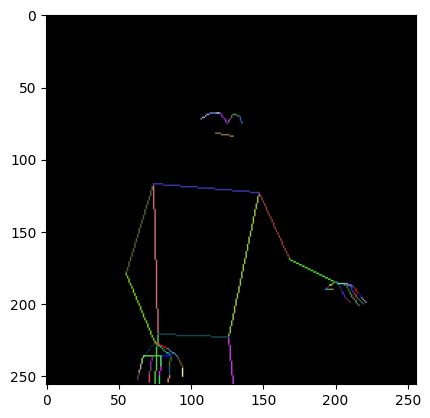

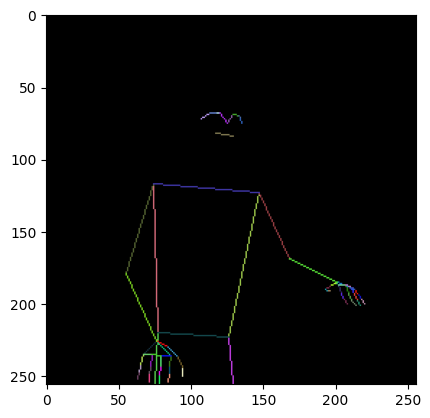

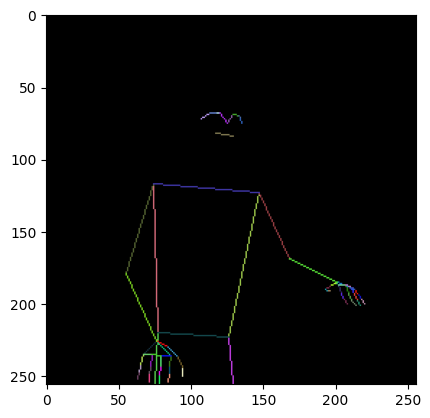

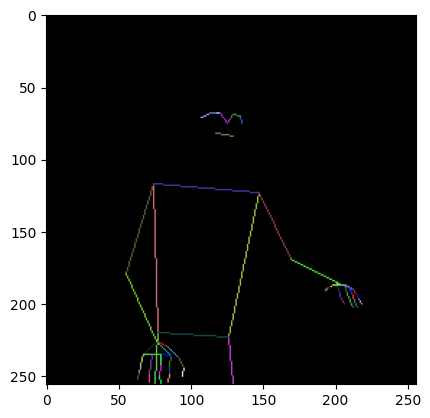

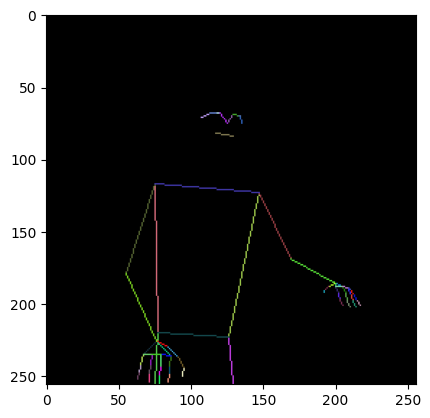

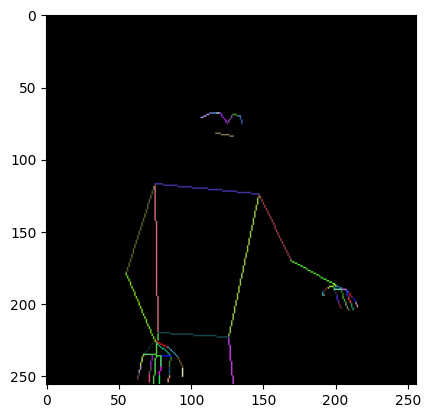

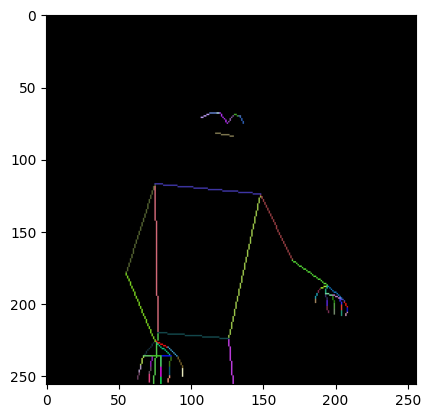

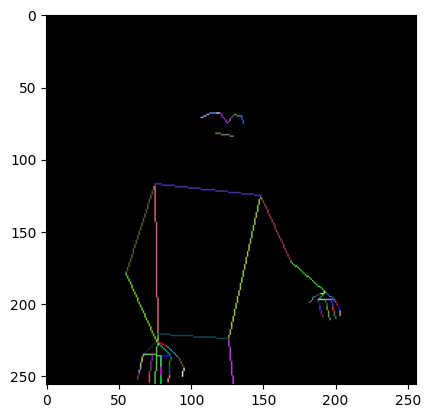

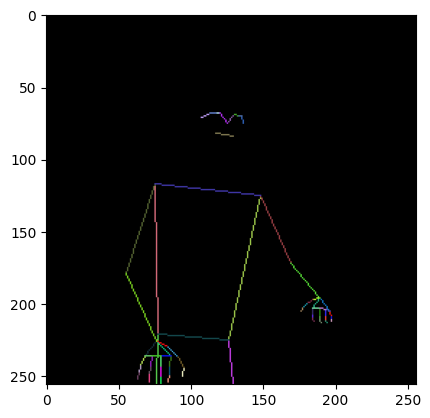

In [20]:
print(len(train_ds[-1][0]))
for f in train_ds[-1][0].permute(0, 2, 3, 1):
    plt.imshow(f)
    plt.show()

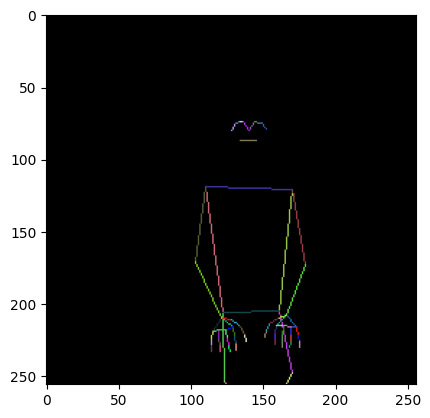

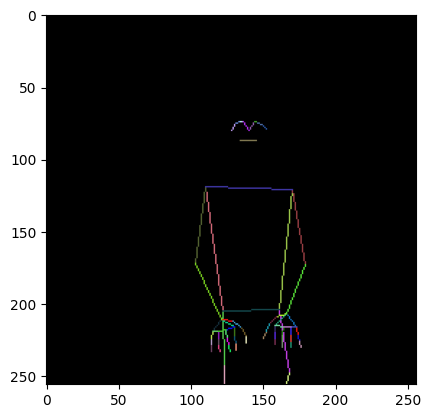

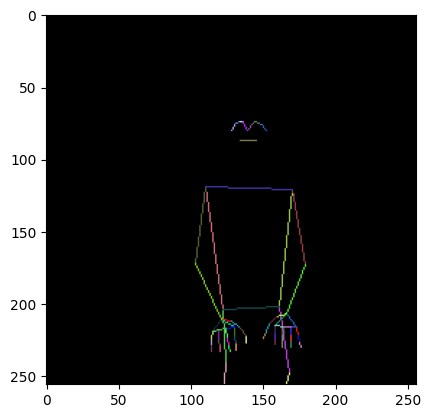

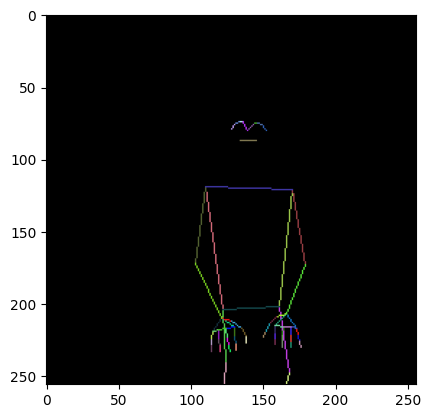

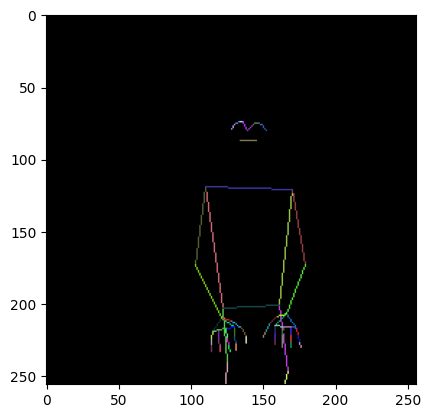

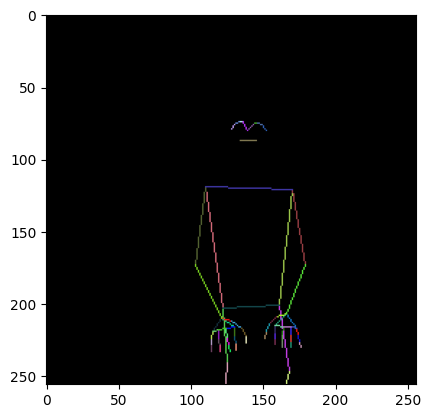

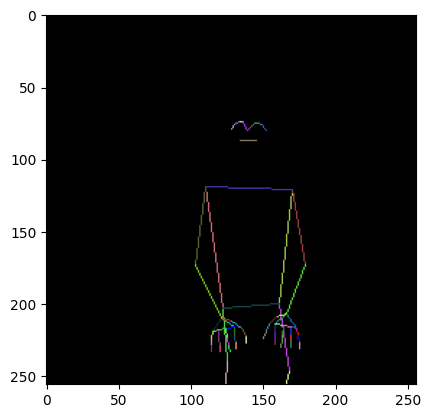

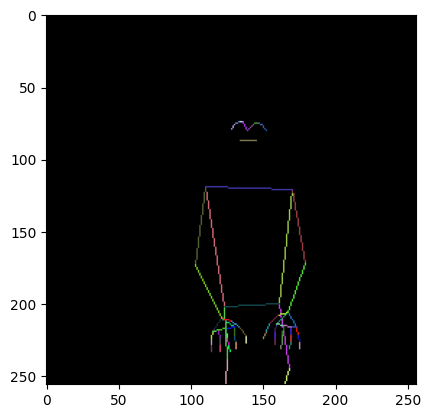

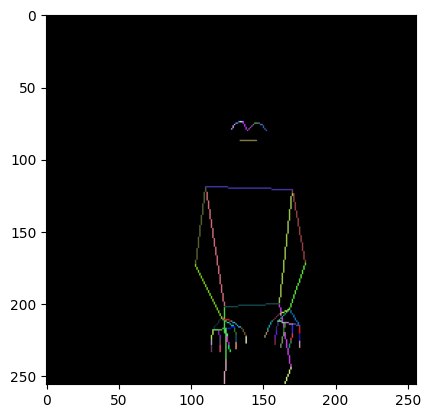

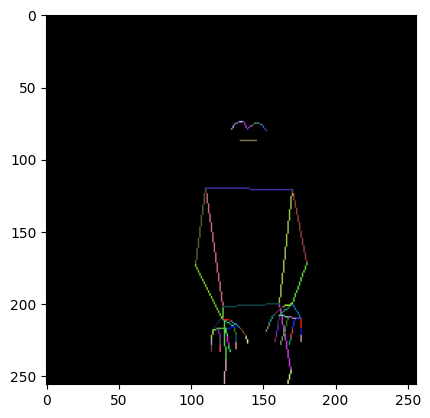

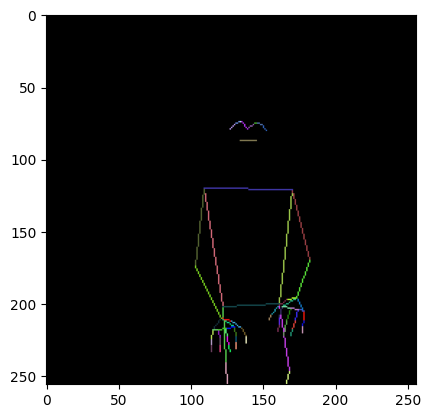

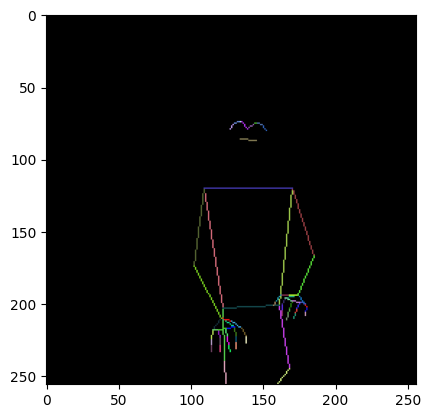

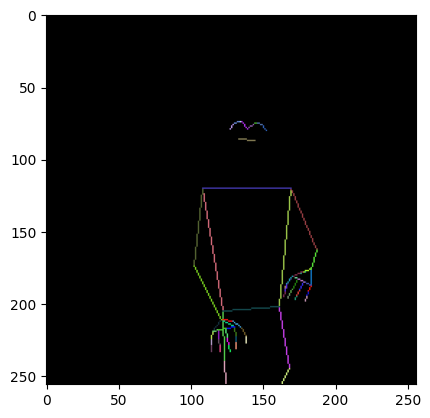

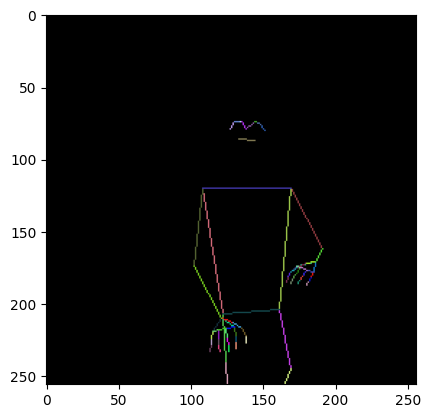

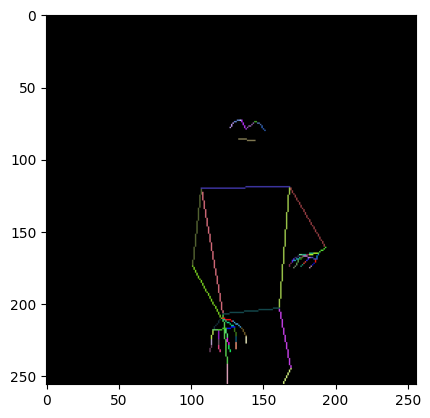

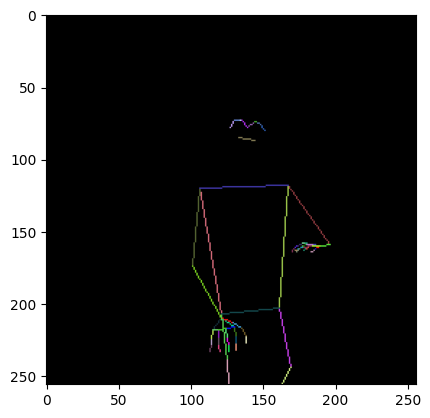

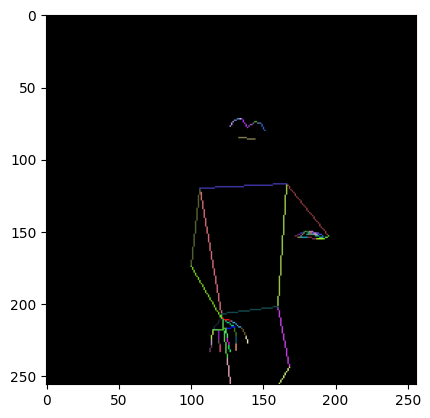

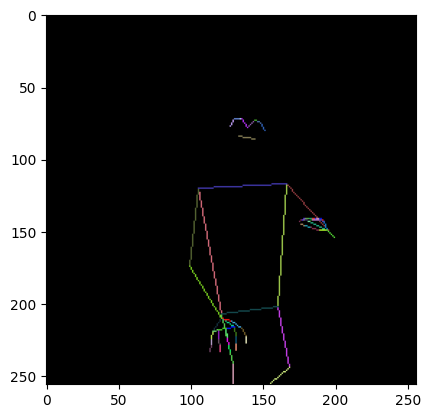

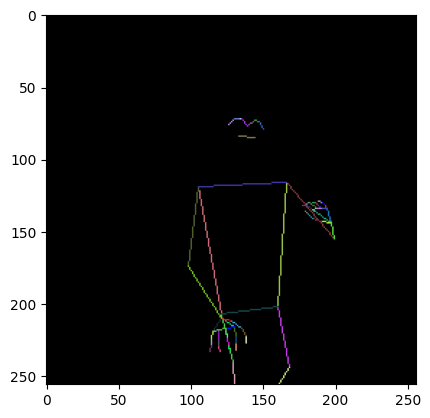

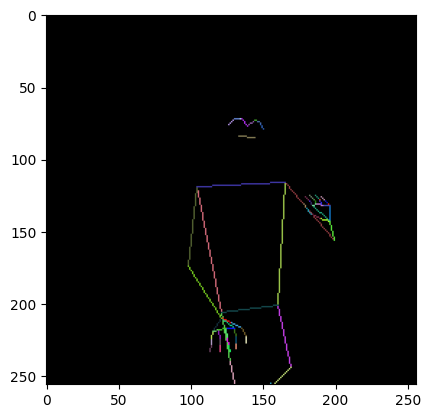

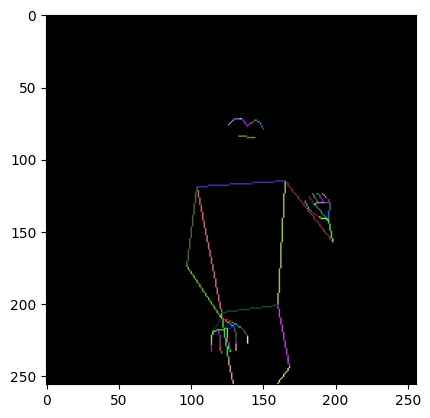

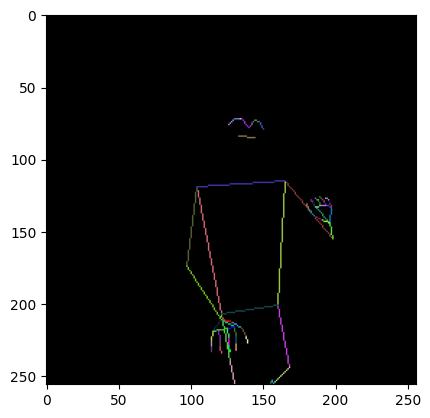

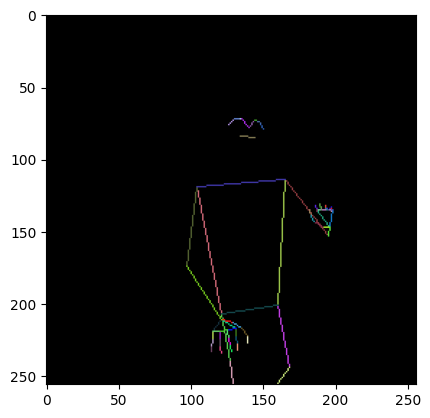

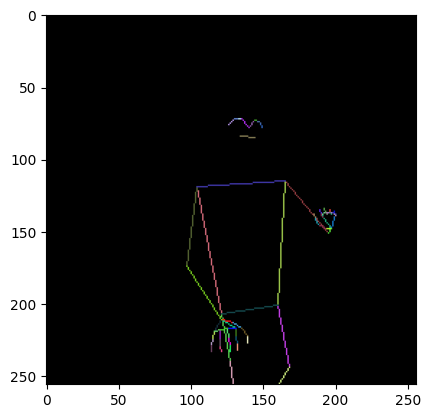

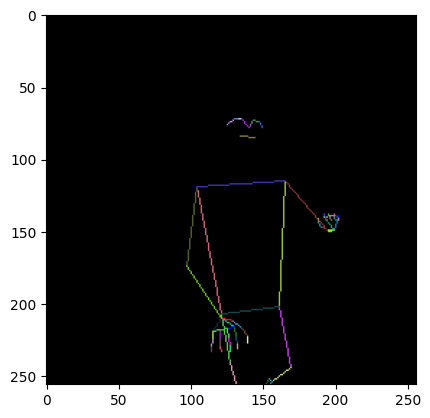

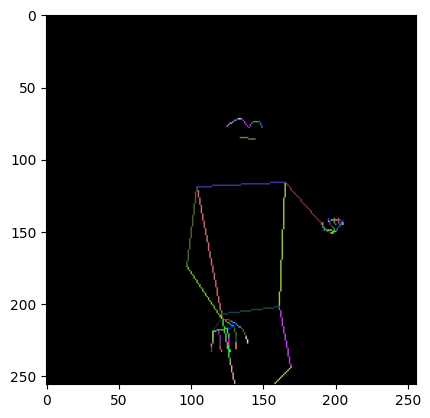

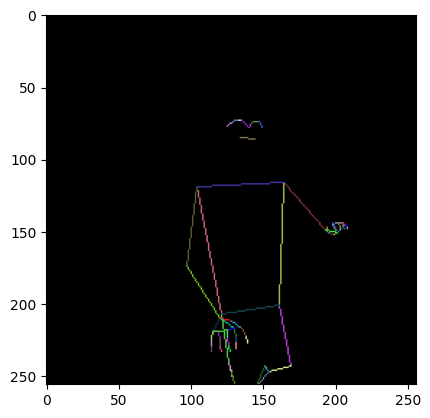

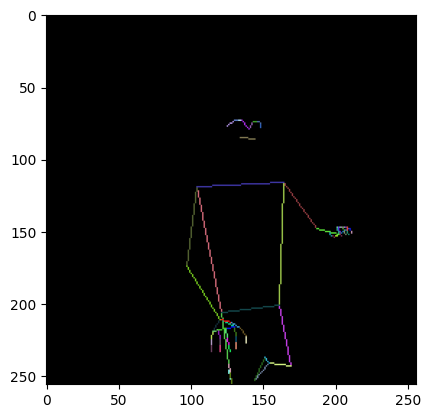

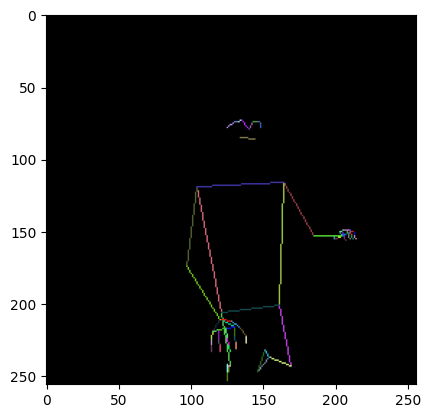

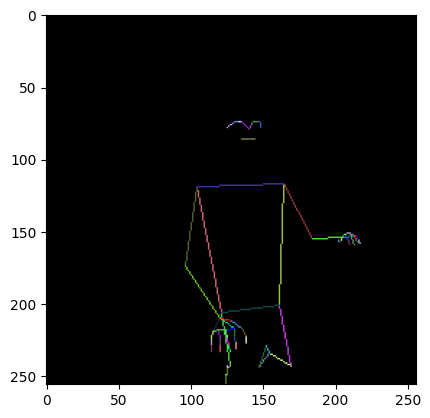

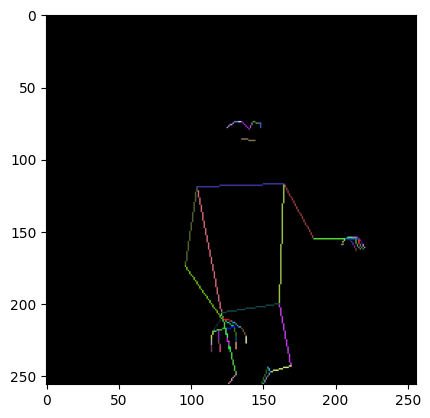

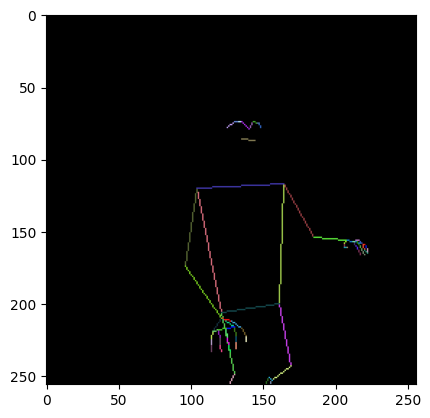

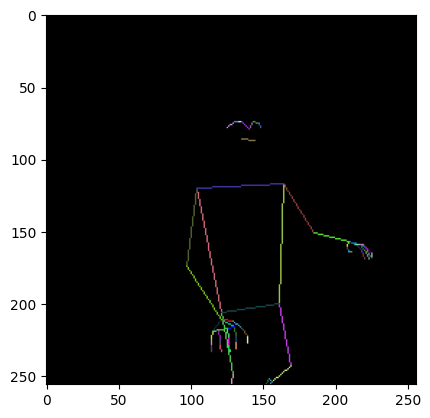

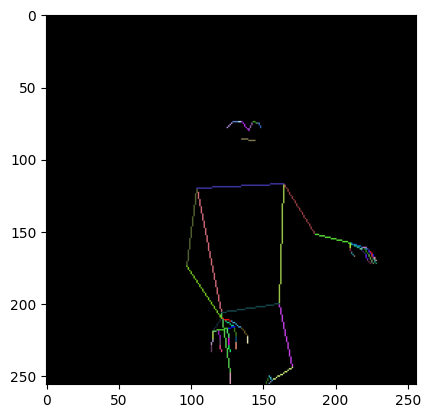

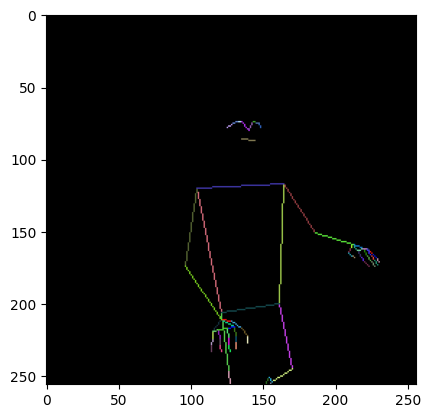

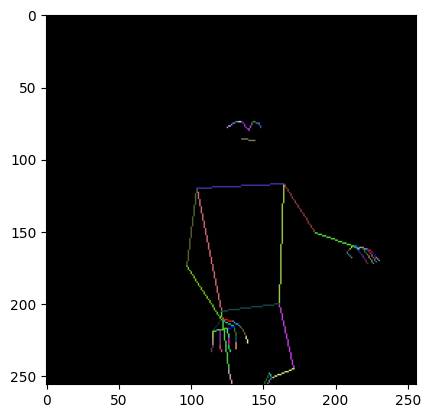

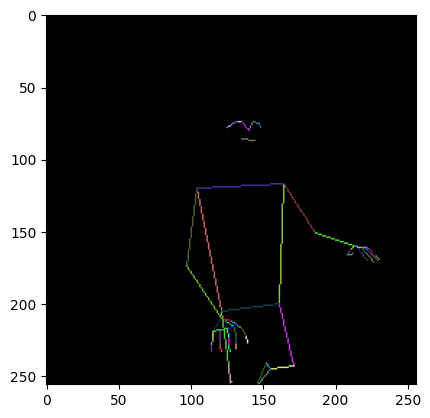

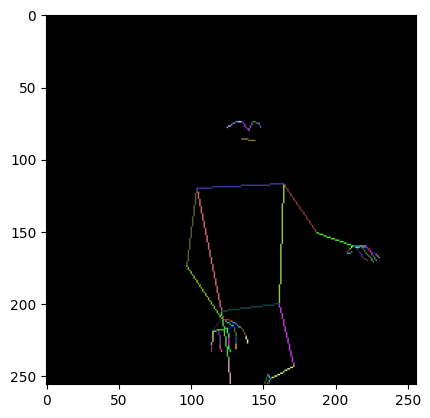

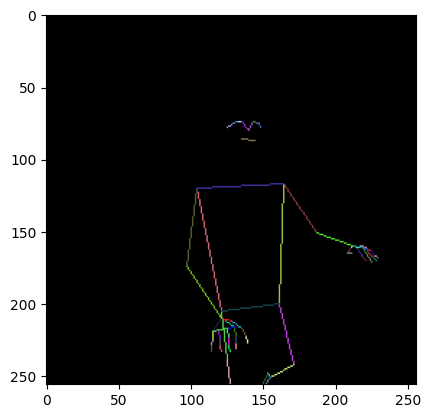

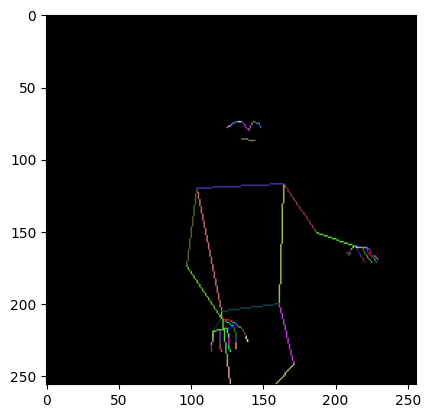

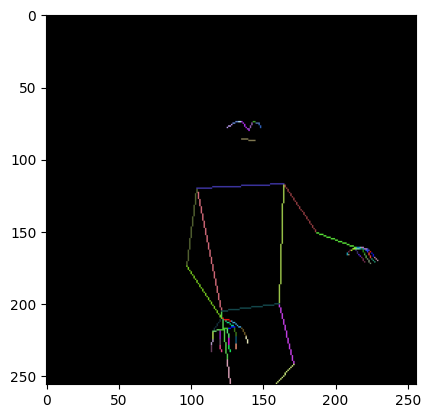

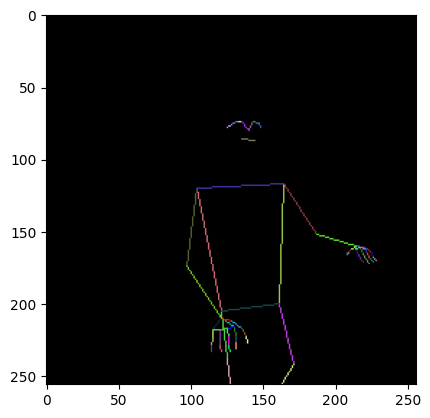

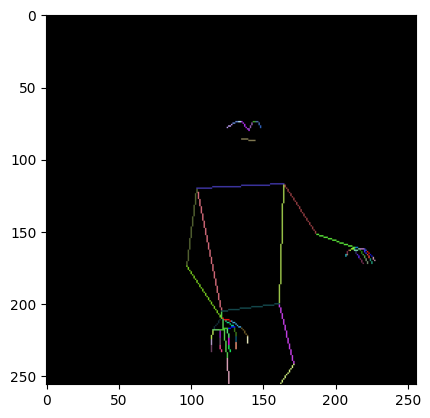

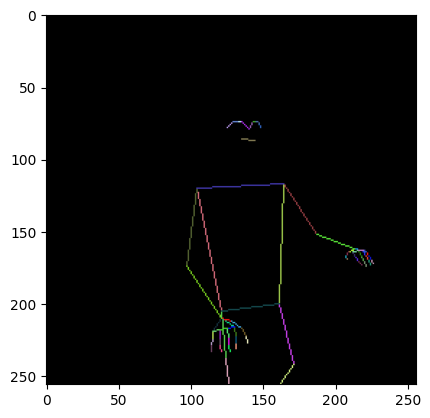

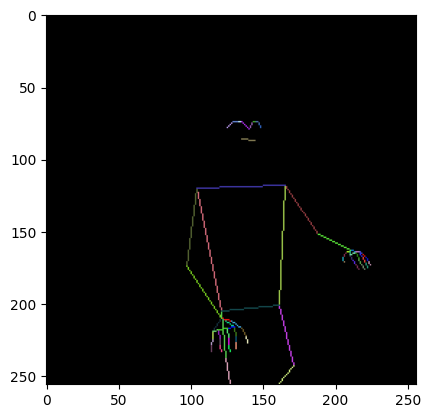

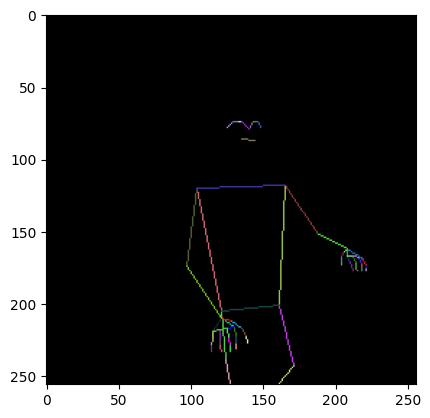

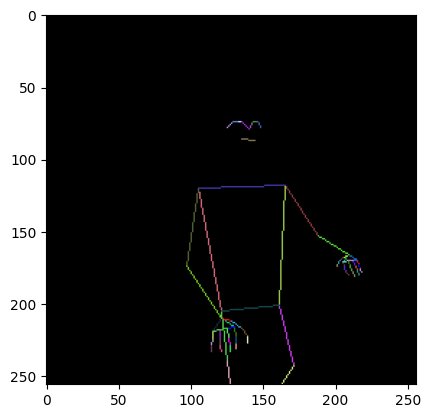

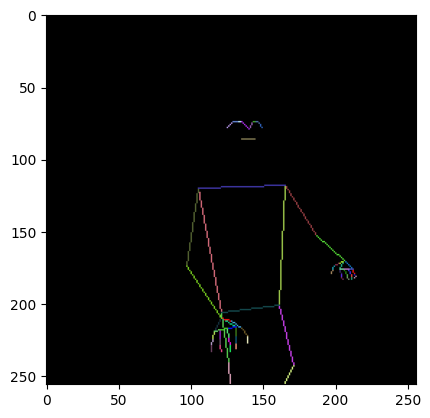

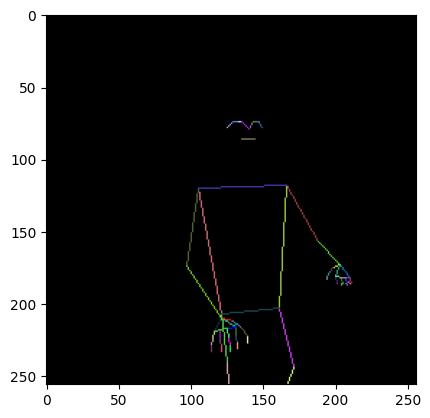

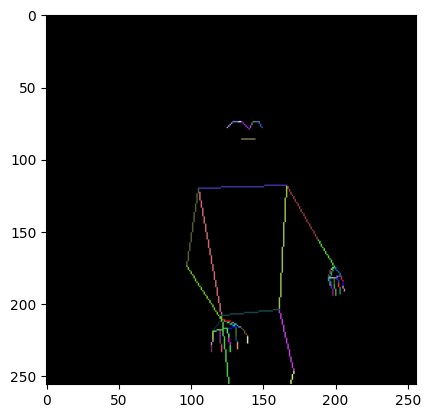

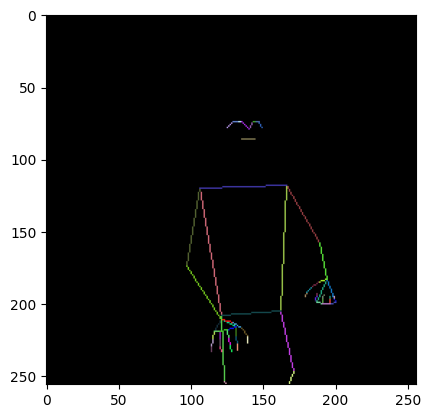

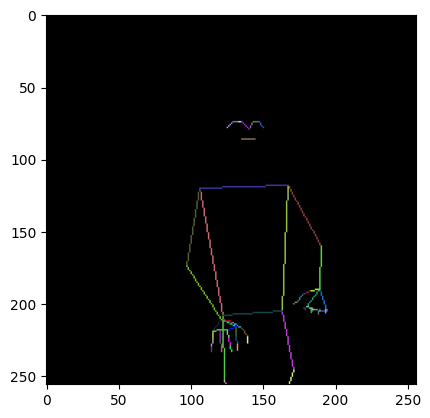

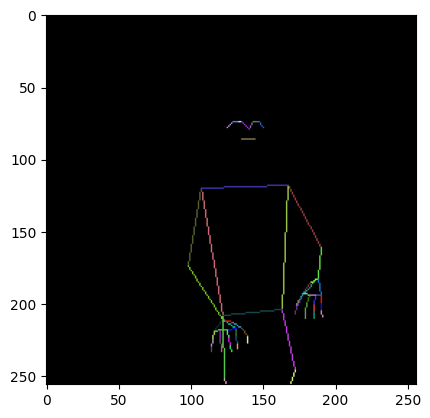

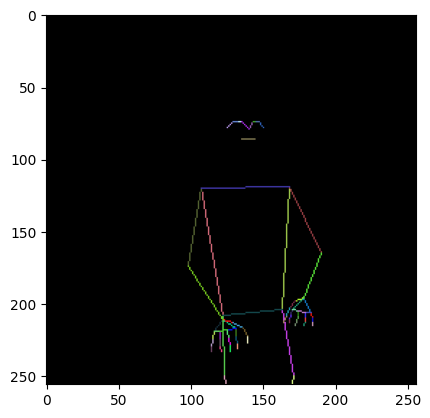

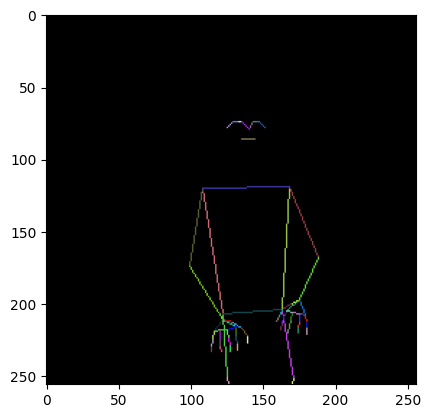

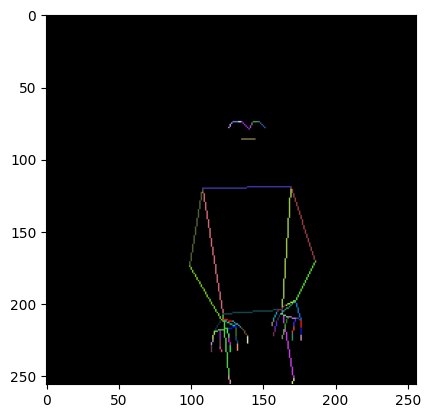

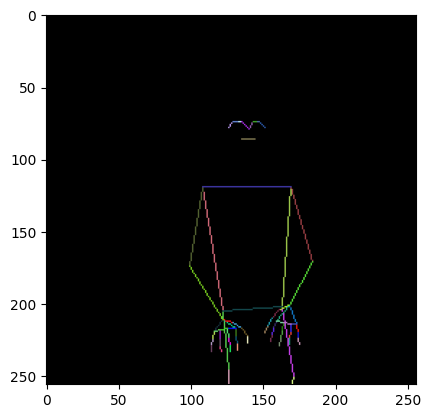

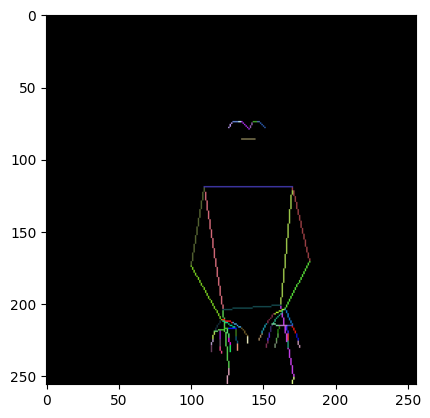

In [21]:
for f in train_ds.samples[-1][1]:#.permute(0, 2, 3, 1):
    plt.imshow(draw_skeleton(f))
    plt.show()

### Model

In [22]:
EMB_SIZE = 32

In [23]:
class SwinTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = swin3d_t(weights=Swin3D_T_Weights.DEFAULT)
        self.model.head = nn.Linear(in_features=768, out_features=num_classes, bias=True)

    def forward(self, X):
        return self.model(X)

In [24]:
class LITModule(pl.LightningModule):
    def __init__(
        self,
        emb_dim: float,
        eta_min: float,
        learning_rate: float,
        loss: str,
        num_classes: int,
        optimizer: str,
        scheduler: str,
        weight_decay: float,
        pretrained_path: str = None,
        pretrained_frame_encoder_path: str = None
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model(pretrained_path, pretrained_frame_encoder_path)

        self.loss_fn = self._init_loss_fn()

        self.metrics = self._init_metrics()
        
        self.transforms = self._init_transforms()

    def _init_model(self, pretrained_path=None, pretrained_frame_encoder_path=None):
        if pretrained_path is not None:
            return torch.load(pretrained_path)
        
        # model = VideoClassifier(
        #         emb_dim=self.hparams.emb_dim,
        #         num_classes=self.hparams.num_classes,
        #     )
        
        model = SwinTransformer(
            num_classes=self.hparams.num_classes)
        
        if pretrained_frame_encoder_path is not None:
            model.frame_enc = torch.load(pretrained_frame_encoder_path)
            
        return model
            

    def _init_loss_fn(self):
        if self.hparams.loss == "Arcface":
            loss = ArcFaceLoss(in_features=EMB_SIZE, num_classes=self.hparams.num_classes)
            if self.model.model.head.in_features != EMB_SIZE:
                self.model.model.head = nn.Linear(768, EMB_SIZE)
            return loss
            
        else:
            raise ValueError(f"{self.hparams.loss} is not a valid loss function")

    def _init_metrics(self):
        metrics = {
                   # 'rocauc': MulticlassAUROC(self.hparams.num_classes),
                   'acc@1' : MulticlassAccuracy(self.hparams.num_classes, top_k=1),
                   'acc@5' : MulticlassAccuracy(self.hparams.num_classes, top_k=5),
                   'acc@10': MulticlassAccuracy(self.hparams.num_classes, top_k=10),
        }
        metric_collection = MetricCollection(metrics)

        return torch.nn.ModuleDict(
            {
                "train_metrics": metric_collection.clone(prefix="train_"),
                "val_metrics": metric_collection.clone(prefix="val_"),
            }
        )

    def configure_optimizers(self):
        optimizer = self._init_optimizer()

        scheduler = self._init_scheduler(optimizer)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

    def _init_optimizer(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = torch.optim.AdamW(
                params=self.parameters(),
                lr=self.hparams.learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {self.hparams.optimizer}")
        return optimizer

    def _init_scheduler(self, optimizer):
        if self.hparams.scheduler == "CosineAnnealingLR":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=self.trainer.max_epochs,
                eta_min=self.hparams.eta_min,
            )
        elif self.hparams.scheduler == "StepLR":
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer,
                step_size=self.trainer.max_epochs // 5,
                gamma=0.95,
            )
        elif self.hparams.scheduler == "OneCycleLR":
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=2.5 / self.trainer.max_epochs,
                final_div_factor=1000,
                div_factor=1000
            )
        else:
            raise ValueError(f"Unknown scheduler: {self.hparams.scheduler}")
        return scheduler
    
    def _init_transforms(self):
        swin_transform = Swin3D_T_Weights.DEFAULT.transforms()
        transforms = {
            # 'train': nn.Sequential(
            #     tf.RandomApply([tf.ElasticTransform()], p=0.5),
            #     tf.RandomPhotometricDistort(p=0.9),
            #     tf.RandomPerspective(distortion_scale=0.35, p=0.7),
            #     swin_transform),
            'train' : swin_transform,
            'val': swin_transform
        }
        
        # transforms = {
        #     'train': transform,
        #     'val': transform
        # }
            
        return transforms

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        return self._shared_step(batch, "train")

    def on_train_epoch_end(self):
        self._log_on_epoch_end('train')

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def on_validation_epoch_end(self):
        self._log_on_epoch_end('val')

    # TODO
    def predict_step(self, batch, batch_idx):
        _, labels, logits = self._forward_pass(batch, stage=None)
        preds = F.softmax(logits, dim=-1)
        return preds, labels

    def _shared_step(self, batch, stage):
        x, y, emb = self._forward_pass(batch, stage)

        loss, y_pred = self.loss_fn(emb, y)

        self.metrics[f"{stage}_metrics"](y_pred, y)

        self._log_on_step(stage, loss, batch_size=len(x))

        return loss

    def _forward_pass(self, batch, stage):
        x, y = batch
        y = y.view(-1)
        # batch_size, seq_len = x.shape[:2]
        # x = self.transforms[stage](x.flatten(0, 1))
        # x = x.reshape(batch_size, seq_len, *x.shape[1:])
        x = self.transforms[stage](x)
        emb = self(x)

        return x, y, emb

    def _log_on_step(self, stage, loss, batch_size):
        self.log(f"{stage}_loss", loss, batch_size=batch_size)

    def _log_on_epoch_end(self, stage):
        self.log_dict(self.metrics[f"{stage}_metrics"])
        
    def on_before_optimizer_step(self, optimizer):
        norms = grad_norm(self.model, norm_type=2)
        self.log("grad_2.0_norm_total", norms["grad_2.0_norm_total"])
        # self.log("grad_2.0_max_val", max(norms.values()))
        

In [25]:
module = LITModule(
    eta_min = 1e-6,
    learning_rate= 5e-5,
    loss = "Arcface",
    num_classes=NUM_CLASSES,
    emb_dim = EMB_SIZE,
    optimizer = "AdamW",
    scheduler = "OneCycleLR",
    weight_decay= 1e-6,
    pretrained_path=f'models/mp_swint_arcface_32emb_200cls.ckpt',
    # pretrained_frame_encoder_path='frame_enc.ckpt',
)

In [26]:
import wandb
WANDB_APIKEY = 'a5bd0bef55f8b72f59ac12d24f1623ad19eeb67b'
wandb.login(key=WANDB_APIKEY)
logger = WandbLogger(project='gestures', )

wandb: Currently logged in as: eldervald (valoebi). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Train 

In [27]:
# logger = TensorBoardLogger("../tf_logs/", name=f"5mf-img_embs-{cnn_model_name}-{EMB_SIZE}-{num_classes}cls+gradcam")
lr_monitor = LearningRateMonitor(logging_interval='step')
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler
# profiler = AdvancedProfiler(dirpath='./', filename='adv_profiler_logs')
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     logger=logger,
                     accumulate_grad_batches=16,
                     # auto_lr_find=True,
                     log_every_n_steps=1,
                     max_epochs=100,
                     # max_steps=60,
                     val_check_interval=1.0,
                     callbacks=[lr_monitor],
                     # profiler=SimpleProfiler(dirpath='./', filename='profiler_logs'),
                     # profiler=profiler,
                     #track_grad_norm=2,
                     # gradient_clip_val=10,
                     # gradient_clip_algorithm="norm",
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [28]:
# trainer.tune(model, train_loader, val_loader, lr_find_kwargs={"num_training":200})

In [29]:
trainer.fit(module, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type            | Params
--------------------------------------------
0 | model   | SwinTransformer | 27.9 M
1 | loss_fn | ArcFaceLoss     | 6.4 K 
2 | metrics | ModuleDict      | 0     
--------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.526   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [30]:
# trainer.validate(module, test_loader)

In [31]:
torch.save(module.model, f'models/mp_swint_arcface_{EMB_SIZE}emb_{NUM_CLASSES}cls.ckpt')

In [32]:
torch.save(module.loss_fn.weight, f'models/mp_swint_arcface_{EMB_SIZE}emb_{NUM_CLASSES}cls_loss_weight.ckpt')

In [33]:
torch.save(module, f'models/pl_mp_swint_arcface_{EMB_SIZE}emb_{NUM_CLASSES}cls.ckpt')

In [34]:
# torch.save(module.model.video_encoder.frame_enc, f'frame_enc.ckpt')

In [35]:
# F.softmax(module.model.video_encoder.temporal_enc.alpha)

In [36]:
x = next(iter(train_loader))[0]

In [37]:
trans = tf.Compose([
        tf.RandomPhotometricDistort(p=0.9),
        tf.RandomApply([tf.ElasticTransform()], p=0.5),
        tf.RandomPerspective(distortion_scale=0.35, p=0.7),
        Swin3D_T_Weights.DEFAULT.transforms()
])

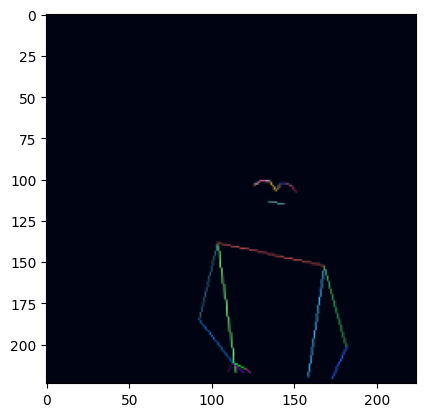

In [38]:
res = trans(x)
img = res[0,:, 0]
img -= img.min()
img /= img.max()
plt.imshow(img.permute(1, 2, 0))

In [39]:
# module = torch.load('pl_swint_arcface.ckpt')
module.loss_fn.weight = torch.load(f'swint_arcface200cls_loss_weight.ckpt')

FileNotFoundError: [Errno 2] No such file or directory: 'swint_arcface200cls_loss_weight.ckpt'

In [40]:
RESIZE_SHAPE = 280
SEED = 54

def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    
#     if len(frames) > 0:
#         frames = frames[len(frames) // 2-2:len(frames) // 2+3]
    
    return np.array(frames)

transform = A.Compose([
     A.LongestMaxSize(max_size=RESIZE_SHAPE),
])
        
def uniform_temporal_subsample(data, n_samples=FRAMES_PER_VIDEO):
    n_frames = len(data)
    indices = np.round(np.linspace(0, n_frames - 1, n_samples)).astype(np.int32)
    data = data[indices]
    return data

def apply(video):
    video = uniform_temporal_subsample(video)
    res = []
    for frame in video:
        res.append(transform(image=frame)['image'])
    return np.array(res)

In [41]:
tr = tf.Compose([
    apply,
    NpToTensor(),
    Swin3D_T_Weights.DEFAULT.transforms(),
])

In [42]:
custom_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/custom/cls/',
                    loader=read_video,
                    transform=tr,
                    extensions=('.mp4'), )

In [43]:
# custom_loader = DataLoader(custom_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

In [89]:
eval_ds = SkeletonDS('data/autsl_skeleton/val_skeleton.pickle', 
                    'data/autsl/val_labels.csv',
                    NpToTensor(),
                    None,
                    random_binned_tss)
eval_samples = [s for s in eval_ds.samples if s[0] >= 200]
eval_ds.samples = eval_samples

In [90]:
eval_loader = DataLoader(eval_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

In [91]:
len(eval_ds)

513

In [92]:
module.cuda();

In [121]:
embs = []
yy = []

for i, (x,y) in zip(range(0,1500), tqdm(eval_loader)):
    if i % 1 != 0:
        continue
    # x = Swin3D_B_Weights.DEFAULT.transforms()(x.cuda())
    with torch.no_grad():
        emb = module._forward_pass((x.cuda(), y.cuda()), 'val')[-1].detach().cpu()
    embs.append(emb)
    yy.append(y.cpu())

  0%|          | 0/513 [00:00<?, ?it/s]

In [122]:
embs = torch.cat(embs)
yy = torch.cat(yy)

In [123]:
sort_index = yy.argsort()
embs = embs[sort_index]
yy = yy[sort_index]

In [124]:
embs.shape, yy.shape

(torch.Size([513, 32]), torch.Size([513]))

In [125]:
from sklearn.manifold import TSNE

In [126]:
res = TSNE(2,).fit_transform(F.normalize(embs,).numpy())

In [127]:
cls_embs = embs[torch.tensor(list({cls.item(): i for i, cls in enumerate(yy)}.values()))]

In [128]:
cls_color = np.random.rand(yy.numpy().max()+1, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


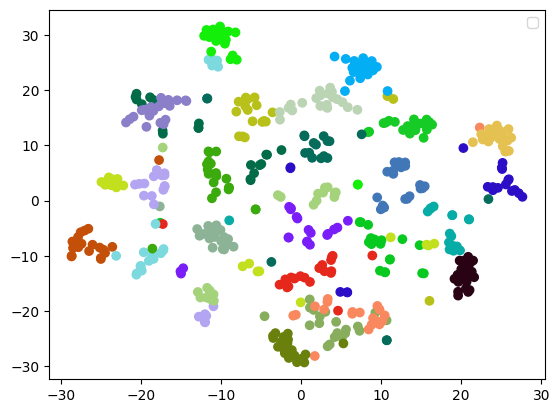

In [129]:
plt.scatter(res[:, 0], res[:, 1], c=cls_color[yy.numpy()],)
plt.legend()

In [130]:
from torchmetrics.functional import pairwise_cosine_similarity

In [131]:
d = pairwise_cosine_similarity(cls_embs,embs)

In [132]:
yy[d.argsort()][:40, -20:]

tensor([[220, 220, 205, 205, 220, 203, 203, 205, 203, 203, 205, 200, 206, 205,
         203, 200, 205, 200, 200, 200],
        [214, 222, 202, 201, 201, 202, 209, 201, 201, 201, 201, 201, 201, 201,
         201, 201, 201, 201, 201, 201],
        [210, 210, 210, 210, 202, 202, 210, 210, 210, 210, 202, 202, 210, 210,
         210, 210, 202, 202, 210, 202],
        [213, 212, 201, 201, 201, 201, 201, 203, 203, 203, 203, 203, 203, 203,
         203, 203, 203, 203, 203, 203],
        [205, 206, 204, 209, 200, 200, 209, 204, 204, 204, 204, 204, 204, 204,
         204, 204, 204, 204, 204, 204],
        [211, 204, 212, 216, 205, 204, 216, 204, 205, 200, 205, 211, 205, 209,
         216, 205, 205, 205, 205, 205],
        [212, 208, 221, 208, 212, 225, 208, 208, 208, 212, 212, 212, 212, 212,
         200, 212, 208, 206, 206, 206],
        [207, 201, 201, 221, 222, 201, 207, 221, 212, 207, 207, 207, 207, 207,
         207, 207, 207, 207, 207, 207],
        [204, 206, 208, 208, 208, 208, 208, 208,

In [133]:
embs.shape

torch.Size([513, 32])

<Axes: >

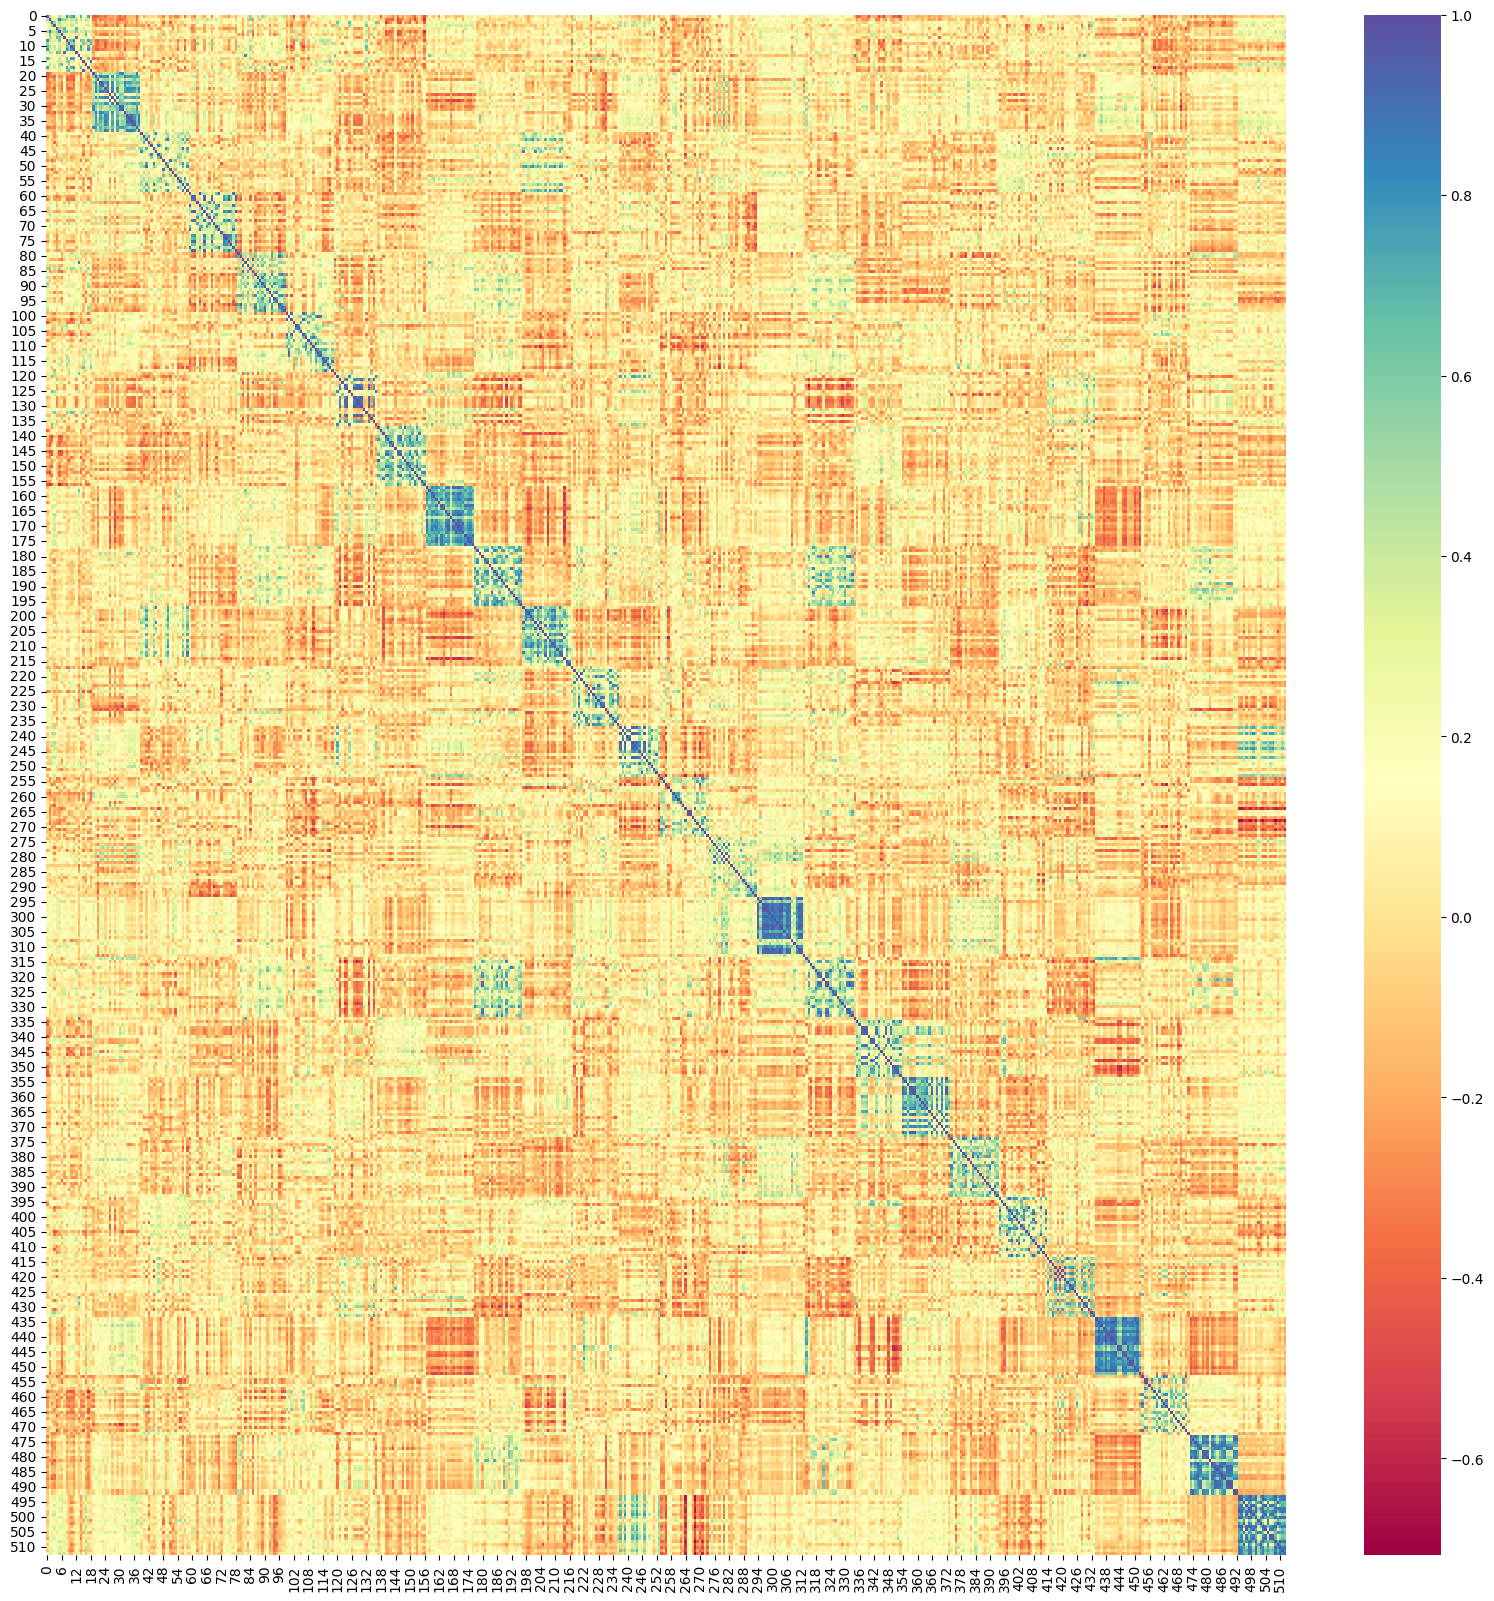

In [134]:
plt.figure(figsize=(20,20))
sns.heatmap(pairwise_cosine_similarity(embs,embs), annot=False, cmap='Spectral')
# plt.savefig('train_conf_mat.png')

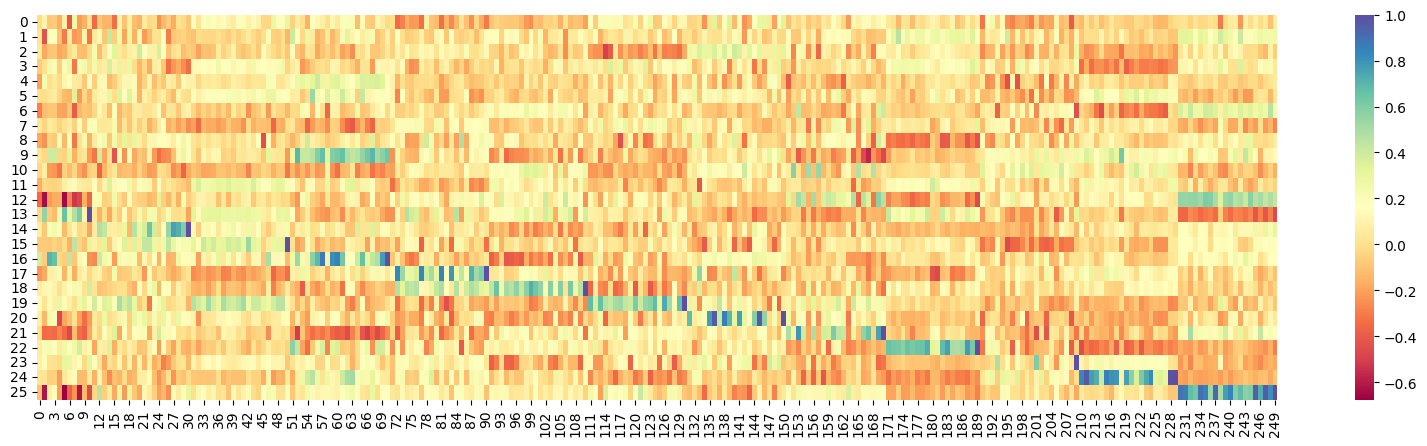

In [138]:
plt.figure(figsize=(20,5))
sns.heatmap(d[:, -250:], annot=False, cmap='Spectral')
plt.savefig('train_conf_mat.png')

In [140]:
d.argsort(dim=0)

tensor([[ 7,  7,  7,  ..., 13, 13, 13],
        [17, 22, 23,  ..., 22, 24, 22],
        [ 3, 17,  1,  ...,  7, 22,  7],
        ...,
        [11, 10,  4,  ..., 14,  6, 14],
        [ 0, 20, 21,  ..., 12, 12, 12],
        [ 4, 25,  6,  ..., 25, 25, 25]])

In [141]:
mask = torch.ones(len(yy))
mask[torch.tensor(list({cls: i for i, cls in enumerate(yy.numpy())}.values()))] = 0
mask = mask.bool()
# print(mask.long())
# mask26 = mask.clone()
# mask26[yy<200] = 0

In [142]:
yy.argsort()

tensor([  1,   0,  18,  17,  16,  15,  14,  13,  12,  11,   9,   8,   7,   6,
          5,   4,   3,   2,  10,  29,  30,  31,  32,  33,  35,  36,  37,  38,
         34,  27,  28,  20,  21,  22,  23,  19,  24,  25,  26,  58,  57,  56,
         55,  54,  53,  52,  51,  50,  49,  47,  46,  45,  44,  43,  42,  41,
         40,  39,  48,  70,  71,  72,  73,  74,  75,  76,  77,  78,  64,  68,
         69,  60,  61,  62,  63,  59,  65,  66,  67,  98,  97,  96,  95,  94,
         93,  92,  91,  90,  89,  87,  88,  79,  80,  81,  82,  83,  84,  85,
         86, 118, 117, 116, 115, 114, 113, 112, 111, 110, 108, 107,  99, 100,
        101, 102, 103, 104, 105, 106, 109, 132, 136, 135, 134, 133, 131, 130,
        129, 128, 126, 127, 120, 121, 122, 123, 119, 124, 125, 147, 156, 155,
        154, 153, 152, 151, 150, 149, 148, 146, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 157, 176, 175, 174, 173, 172, 171, 170, 169, 168, 166,
        165, 164, 163, 162, 161, 160, 159, 158, 167, 187, 188, 1

In [143]:
# mask26

In [148]:
top1 = MulticlassAccuracy(yy.max().item() + 1 - 200, top_k=1)
top1(d.T[mask]-200, yy[mask]-200)

tensor(0.5286)

In [149]:
top5 = MulticlassAccuracy(yy.max().item() + 1 - 200, top_k=5)
top5(d.T[mask]-200, yy[mask]-200)

tensor(0.8052)

In [150]:
top10 = MulticlassAccuracy(yy.max().item() + 1 - 200, top_k=10)
top10(d.T[mask]-200, yy[mask]-200)

tensor(0.8865)

In [152]:
roc_auc = MulticlassAUROC(26)
roc_auc(d.T[mask]-200, yy[mask]-200)

tensor(0.9005)

In [153]:
mask.long()[:100:]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1])

In [158]:
from collections import defaultdict
avg = defaultdict(list)

for cls in tqdm(set(yy.numpy())):
    dd = d[cls-200, mask]
    # print(dd.shape)
    for c,b in zip(yy[mask].numpy(), dd.numpy()):
        avg[(cls, c)].append(b)

  0%|          | 0/26 [00:00<?, ?it/s]

In [159]:
avg = {k: np.mean(v) for k,v in avg.items()}

In [160]:
d.shape, yy.shape

(torch.Size([26, 513]), torch.Size([513]))

In [161]:
[(i, avg[(67,i)]) for i in set(yy.numpy()) if i < 200]

[]

In [162]:
np.min([i for i in avg.values()])

-0.42790413

In [166]:
avg_pwcls_dist = np.zeros((26, 26))
for (a, b), v in avg.items():
    avg_pwcls_dist[a-200, b-200] = v

<Axes: >

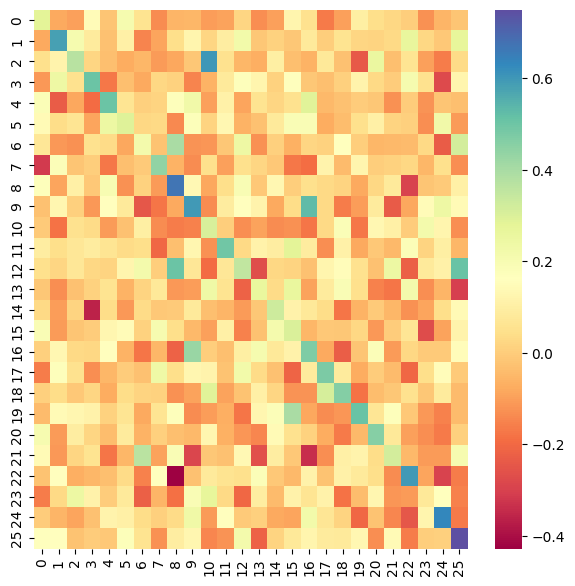

In [169]:
plt.figure(figsize=(7,7))
sns.heatmap(avg_pwcls_dist, annot=False, cmap='Spectral')
# plt.savefig('train_conf_mat.png')